In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

import matplotlib.lines as mlines

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [4]:
GALARY = '/tigress/jiaxuanl/public_html/galary'

In [5]:
from paper_figure import quenched_frac

In [6]:
date = '221025'

In [7]:
### UDG ###
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89
print('Total angular area [deg2]:', total_area)


fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 89


In [8]:
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

Total angular area [deg2]: 89


In [9]:
for q in [0.25, 0.5, 0.75]:
    print(np.quantile(udg_cat['g-i'], q))

0.5030835430264501
0.7087066377829495
0.8217609164329446


In [10]:
ra, dec = fake_udg_cat['ra'], fake_udg_cat['dec']

In [ ]:
345, 347, 349
2.5, 1.5, 0.5, -0.5, -1.5

349, 351
1.5, -0.5

353-355
1.5, -0.5

In [17]:
flags = [(ra < 347) & (ra > 345) & (dec < 2.5) & (dec > 0.5), 
         (ra < 347) & (ra > 345) & (dec < 0.5) & (dec > -1.5), 
#          (ra < 349) & (ra > 347) & (dec < 2.5) & (dec > 0.5), 
         (ra < 349) & (ra > 347) & (dec < 0.5) & (dec > -1.5),
         (ra < 351) & (ra > 349) & (dec < 1.5) & (dec > -0.5),
         (ra < 355) & (ra > 353) & (dec < 1.5) & (dec > -0.5),]

In [19]:
[np.sum(item) for item in flags]

[2351, 1163, 1181, 1554, 1913]

In [22]:
for q in [0.25, 0.5, 0.75]:
    gis = []
    print(f'q={q}')
    for flag in flags:
        gi = np.quantile(fake_udg_cat['g-i'][flag], q)
        gis.append(gi)
        print(gi)
    print(np.mean(gis), np.std(gis))

q=0.25
0.4511988870114523
0.3146530362832725
0.42208803366371667
0.3374292676296039
0.5905326860401333
0.42318038212563575 0.09790246360494573
q=0.5
0.6128426358765834
0.36882039051325977
0.423155484193694
0.4430294515193319
0.6951833777241663
0.508606267965407 0.12395038129728785
q=0.75
0.8272057070981447
0.49266303559536084
0.6775636555105397
0.512068221960177
0.7474623867510355
0.6513926013830516 0.13071414126459222


In [11]:
flag = (fake_udg_cat['ra'] < 348)
np.sum(flag), np.sum(~flag)

(3968, 4299)

0.42208803366371667
0.5387573252122914
0.7242689168600227


In [13]:
for q in [0.25, 0.5, 0.75]:
#     print(np.quantile(fake_udg_cat['g-i'][flag], q))
    print(np.quantile(fake_udg_cat['g-i'][~flag], q))

0.42313446037026325
0.5387573252122914
0.7242689168600227


In [14]:
flag = (fake_udg_cat['dec'] < 0.5)
np.sum(flag), np.sum(~flag)

(3890, 4377)

In [15]:
for q in [0.25, 0.5, 0.75]:
    print(np.quantile(fake_udg_cat['g-i'][flag], q))
    print(np.quantile(fake_udg_cat['g-i'][~flag], q))

0.3605155852266497
0.43140536925049516
0.5053927488189048
0.5819013268743857
0.6775636555105397
0.7474623867510355


% of contaminants in the sample: 44.95 +- 5.88


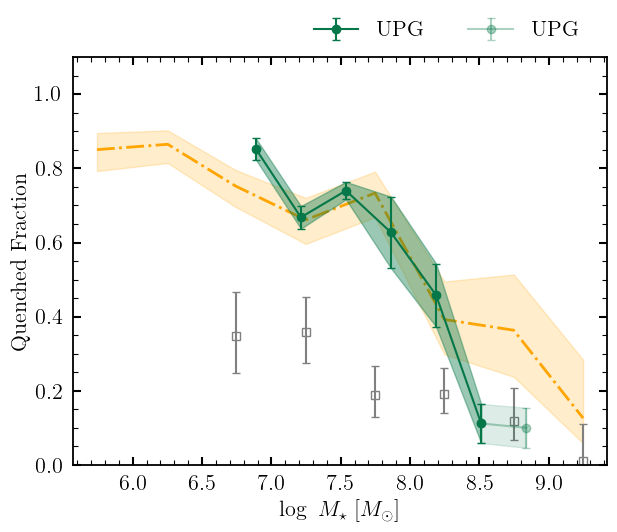

In [39]:
quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
             min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
             name=name.upper(), flag=None, 
             ax=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
              plot_saga=True, plot_sim=False, plot_elves_upg=False)

plt.legend(ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

% of contaminants in the sample: 44.95 +- 5.88


(0.0, 1.0)

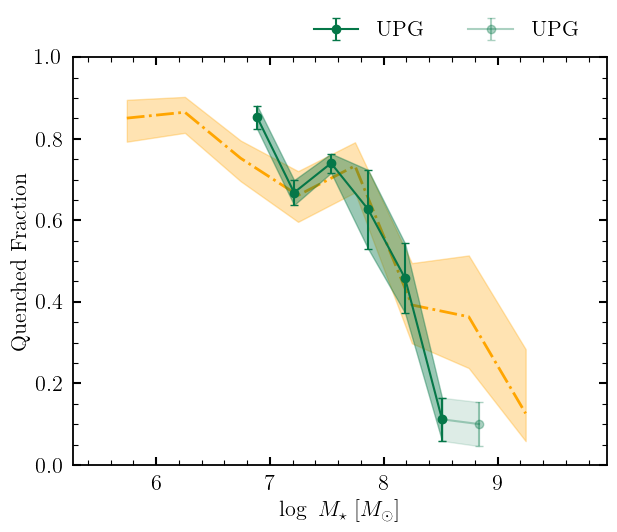

In [39]:
quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
             min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
             name=name.upper(), flag=None, 
             ax=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
              plot_saga=False, plot_elves=True, plot_MW_M31=False, plot_udg=True, plot_sim=False)

plt.legend(ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))
# print(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(5.266386706948641, 9.96587915407855)
plt.ylim(0, 1.)

% of contaminants in the sample: 12.61 +- 2.00
% of contaminants in the sample: 12.61 +- 2.00


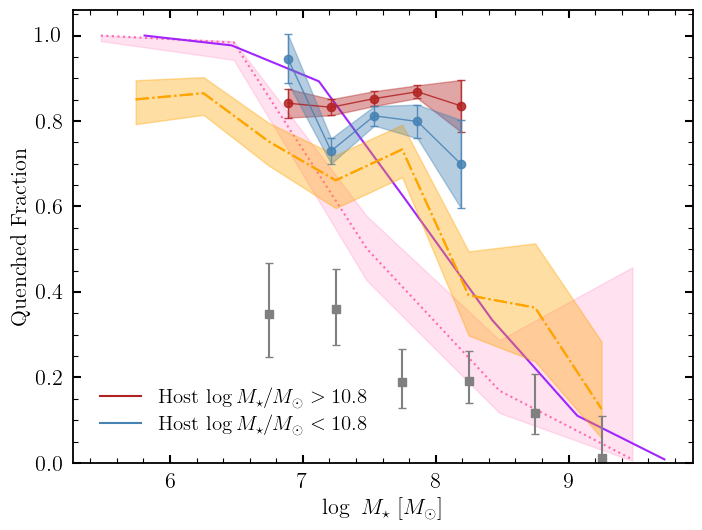

In [13]:
thresh = 10.8

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                        min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                        flag=(udg_cat['host_stellar_mass'] > thresh), 
                        linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_stellar_mass'] <= thresh), linecolor='steelblue', ax=ax, plot_ref=False)


# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))
# ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='firebrick', label=r'Host $\log M_\star / M_\odot > 10.8$')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Host $\log M_\star / M_\odot < 10.8$')

plt.legend(handles=[k_line, b_line], 
           fontsize=15, 
           loc='lower left',
#            bbox_to_anchor=(0., 1.0, 1.3, .0)
          )

% of contaminants in the sample: 15.80 +- 2.60
% of contaminants in the sample: 15.80 +- 2.60


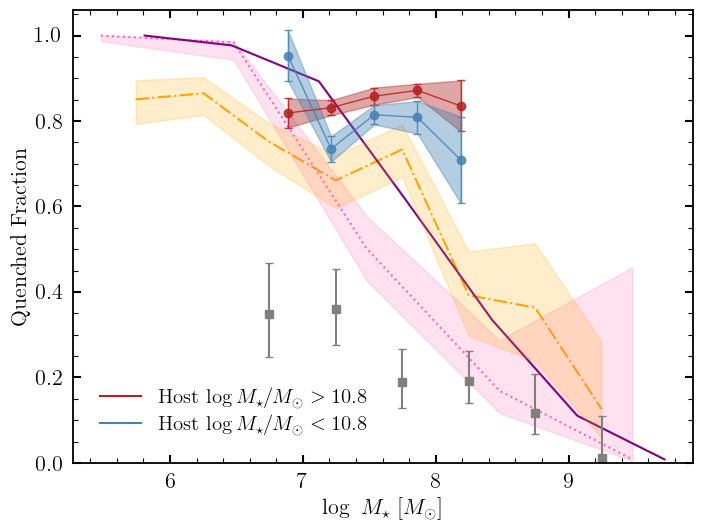

In [67]:
thresh = 10.8

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                        min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
                        flag=(udg_cat['host_stellar_mass'] > thresh), 
                        linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_stellar_mass'] <= thresh), linecolor='steelblue', ax=ax, plot_ref=False)


# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))
# ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='firebrick', label=r'Host $\log M_\star / M_\odot > 10.8$')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Host $\log M_\star / M_\odot < 10.8$')

plt.legend(handles=[k_line, b_line], 
           fontsize=15, 
           loc='lower left',
#            bbox_to_anchor=(0., 1.0, 1.3, .0)
          )

In [14]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

% of contaminants in the sample: 15.80 +- 2.60
% of contaminants in the sample: 15.80 +- 2.60
% of contaminants in the sample: 15.80 +- 2.60


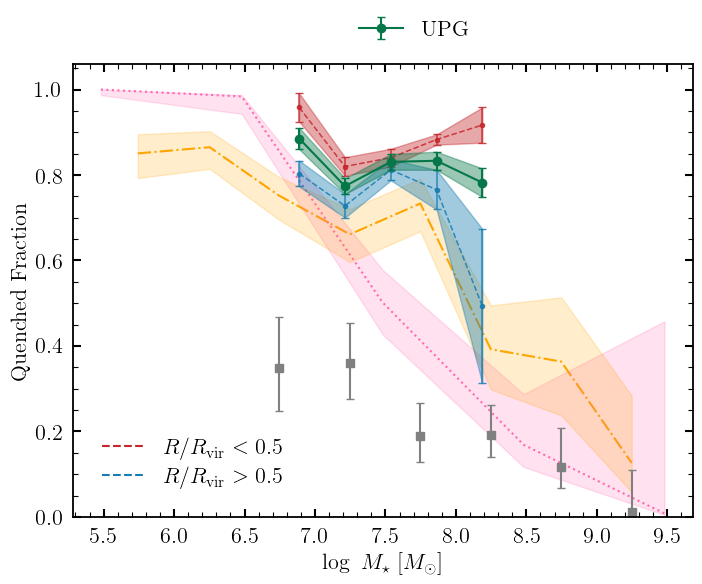

In [17]:
thresh = 0.5

fig, ax = plt.subplots(figsize=(8, 6))

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              name='UPG',
              flag=None, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5,
                        ax=ax, plot_ref=True)


fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(dist_ratio <= thresh), linecolor='#c3272b', fmt='.--', linewidth=1.1,
                        ax=ax, plot_ref=False)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(dist_ratio > thresh), linecolor='#177cb0', fmt='.--', linewidth=1.1,
                        ax=ax, plot_ref=False)


handles, labels = plt.gca().get_legend_handles_labels()
order = [0,]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, loc='upper center', bbox_to_anchor=(0.3, 0.66, 0.5, 0.5))
ax.add_artist(leg)

import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{thresh}$')

plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
          )

In [124]:
import pickle
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)
    
host_gi = []
for name in udg_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)
        
host_gi = np.array(host_gi)

% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96


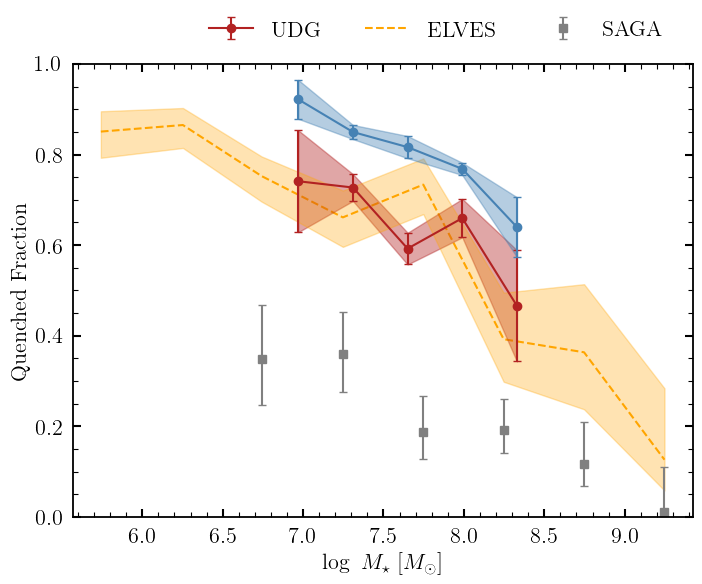

In [125]:
thresh = 1.2

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(host_gi <= thresh), linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(host_gi > thresh), linecolor='steelblue', ax=ax, plot_ref=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

% of contaminants in the sample: 31.72 +- 2.96
% of contaminants in the sample: 31.72 +- 2.96


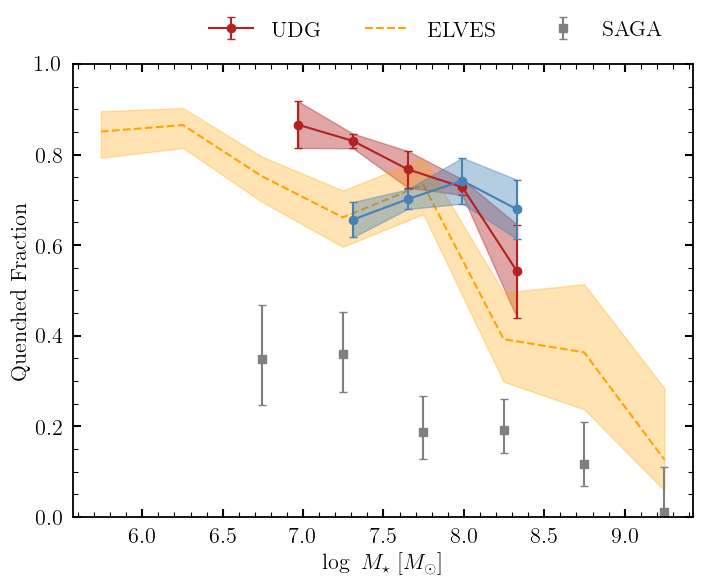

In [127]:
thresh = 0.035

fig, ax = plt.subplots(figsize=(8, 6))
fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_z'] <= thresh), linecolor='firebrick', ax=ax, plot_ref=True)

fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
              min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.28, 
              flag=(udg_cat['host_z'] > thresh), linecolor='steelblue', ax=ax, plot_ref=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]

plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           ncol=3, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

---

## Fig 1: $f_q$ for UDG, UPG, ELVES, SAGA

In [12]:
import matplotlib.lines as mlines
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Total angular area [deg2]: 89
% of contaminants in the sample: 44.95 +- 5.88


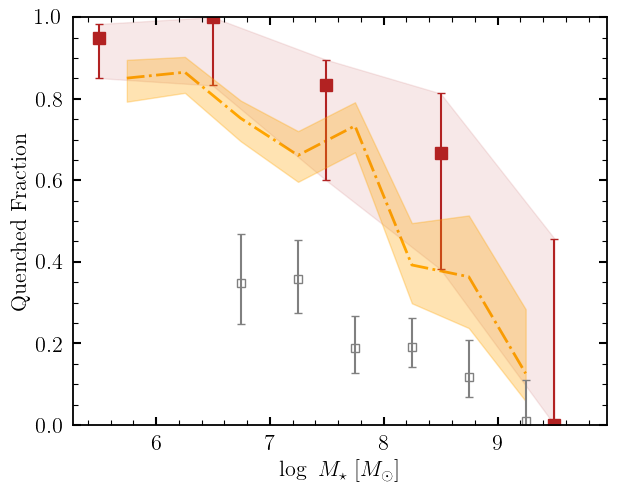

In [14]:
# fig, ax = plt.subplots(figsize=(8, 6))
# fig, ax = plt.subplots(figsize=(6.5, 5.5))
fig, ax = plt.subplots(1, 1, figsize=(6.9, 5.4))

# ### UDG ###
# name = 'udg'
# udg_cat = Table.read(
#     f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
# flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
#        ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
# udg_cat = udg_cat[flag]
# udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

# _, ind = np.unique(udg_cat['host_name'].data, return_index=True)
# total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
# total_area = 89
# print('Total angular area [deg2]:', total_area)

# fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
# fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
# fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
# density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

# fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                       min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                         name=name.upper(), flag=None, 
#                      ax=ax, linecolor='slategrey', linealpha=1, zorder=10, linewidth=1.5, fmt='o--',
#                       plot_saga=False, plot_sim=False, plot_elves_upg=False)

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg


fig, ax = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                      min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                        name=name.upper(), flag=None, 
                     ax=ax, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
                      plot_udg=False, plot_MW_M31=True, plot_saga=True, plot_elves=True, plot_sim=False, plot_elves_upg=False)


# ax.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=18)
# ax.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=18)
# ax.text(8.4, 0.55, 'UPGs', color='#057748', fontsize=19)
# ax.text(8.4, 0.7, 'UDGs', color='slategrey', fontsize=19)

# plt.ylim(0, 1.03)
plt.xlim(5.266386706948641, 9.96587915407855)
plt.ylim(0, 1.)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0]

# plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            ncol=2, bbox_to_anchor=(0.5, 0.66, 0.5, 0.5))

# plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac.pdf', 
#             bbox_inches='tight', dpi=50)

### Host color

In [115]:
import matplotlib.lines as mlines
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96


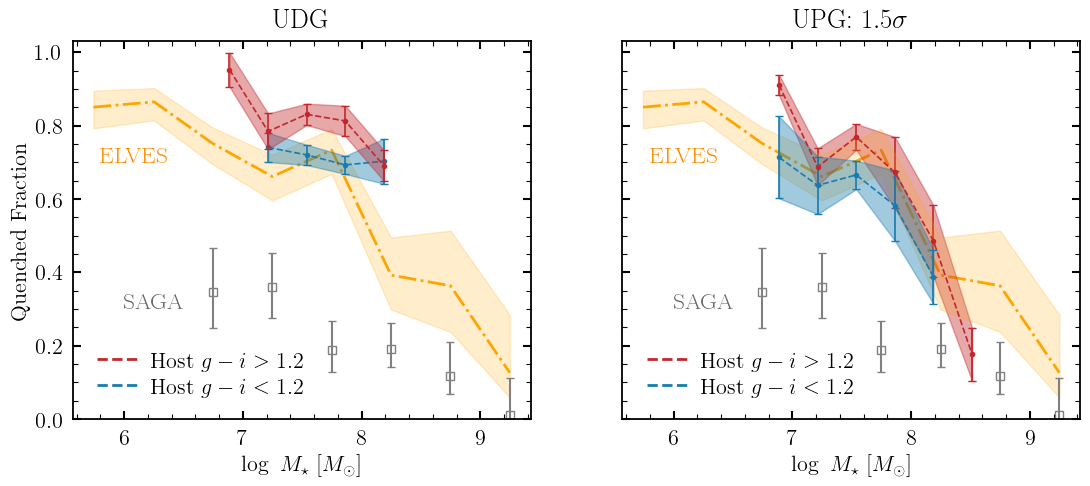

In [44]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]


_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
# fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                          min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                          name=name.upper(), flag=None, 
#                          ax=ax1, linecolor='k', linealpha=1, zorder=10, linewidth=1.5, plot_saga=True)

fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, zorder=10, fmt='.--', linewidth=1.2, 
                         plot_saga=True, plot_elves=True)

fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.2, 
                         plot_saga=False, plot_elves=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
# ax1.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax1.add_artist(leg)
ax1.set_title(r'UDG')
plt.ylim(0, 1.03)

k_line = mlines.Line2D([], [], ls='--', lw=2, color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', lw=2, color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
           handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
# fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                          min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                          name=name.upper() + f': ${thresh}\sigma$', flag=None, 
#                          ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_saga=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.2, 
                         plot_saga=True, plot_elves=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.2, 
                         plot_saga=False, plot_elves=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
# ax2.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax2.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax2.add_artist(leg)
ax2.set_ylabel('')
ax2.set_title(r'UPG: $1.5\sigma$')
plt.ylim(0, 1.03)

k_line = mlines.Line2D([], [], ls='--', lw=2, color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', lw=2, color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
           handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_host_color_new.pdf', 
            bbox_inches='tight', dpi=50)

### Radial bin

Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96


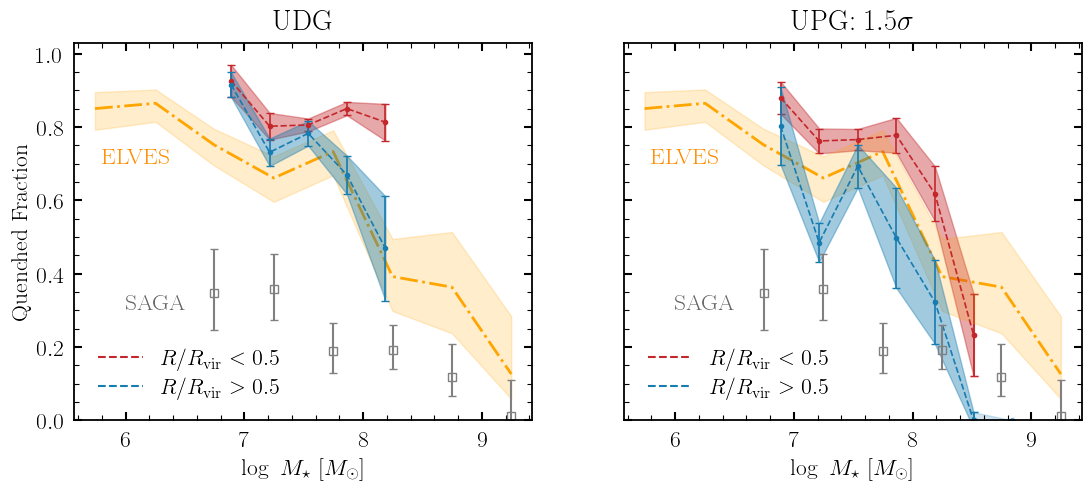

In [127]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
# fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                          min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                          name=name.upper(), flag=None, 
#                          ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_saga=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.2, plot_saga=True, plot_elves=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.2, plot_saga=False, plot_elves=False)
ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
# ax1.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax1.add_artist(leg)
ax1.set_title('UDG')
plt.ylim(0, 1.03)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
#            handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
# fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                          min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                          name=name.upper() + f': ${thresh}\sigma$', flag=None, 
#                          ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_saga=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.2, plot_saga=True, plot_elves=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.2, plot_saga=False, plot_elves=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
# ax2.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax2.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax2.add_artist(leg)
ax2.set_ylabel('')
ax2.set_title('UPG: $1.5\sigma$')
plt.ylim(0, 1.03)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
#            handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_dist2host_new.pdf', 
            bbox_inches='tight', dpi=50)

Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96


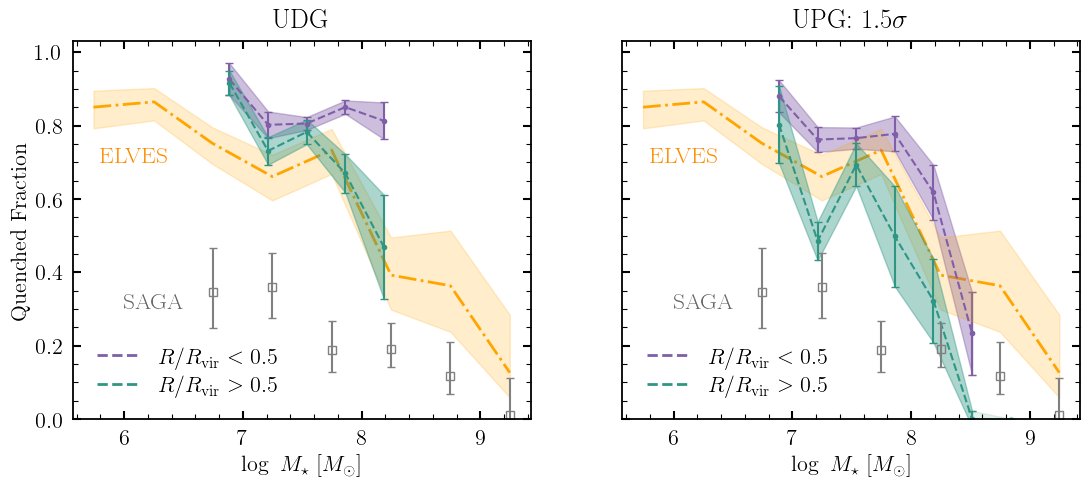

In [45]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
# fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                          min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                          name=name.upper(), flag=None, 
#                          ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_saga=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax1, linecolor='#805ea8', linealpha=1, fmt='.--', linewidth=1.5, plot_saga=True, plot_elves=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax1, linecolor='#2f9683', linealpha=1, fmt='.--', linewidth=1.5, plot_saga=False, plot_elves=False)
ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
# ax1.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax1.add_artist(leg)
ax1.set_title('UDG')
plt.ylim(0, 1.03)

k_line = mlines.Line2D([], [], ls='--', lw=2, color='#805ea8', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', lw=2, color='#2f9683', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
#            handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
# fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
#                          min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
#                          name=name.upper() + f': ${thresh}\sigma$', flag=None, 
#                          ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_saga=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax2, linecolor='#805ea8', linealpha=1, fmt='.--', linewidth=1.5, plot_saga=True, plot_elves=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax2, linecolor='#2f9683', linealpha=1, fmt='.--', linewidth=1.5, plot_saga=False, plot_elves=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
# ax2.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax2.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax2.add_artist(leg)
ax2.set_ylabel('')
ax2.set_title('UPG: $1.5\sigma$')
plt.ylim(0, 1.03)

k_line = mlines.Line2D([], [], ls='--', lw=2, color='#805ea8', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', lw=2, color='#2f9683', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
#            handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_dist2host_new.pdf', 
            bbox_inches='tight', dpi=50)

### ELVES UPG

Total angular area [deg2]: 89.19
% of contaminants in the sample: 45.58 +- 5.96
% of contaminants in the sample: 45.58 +- 5.96


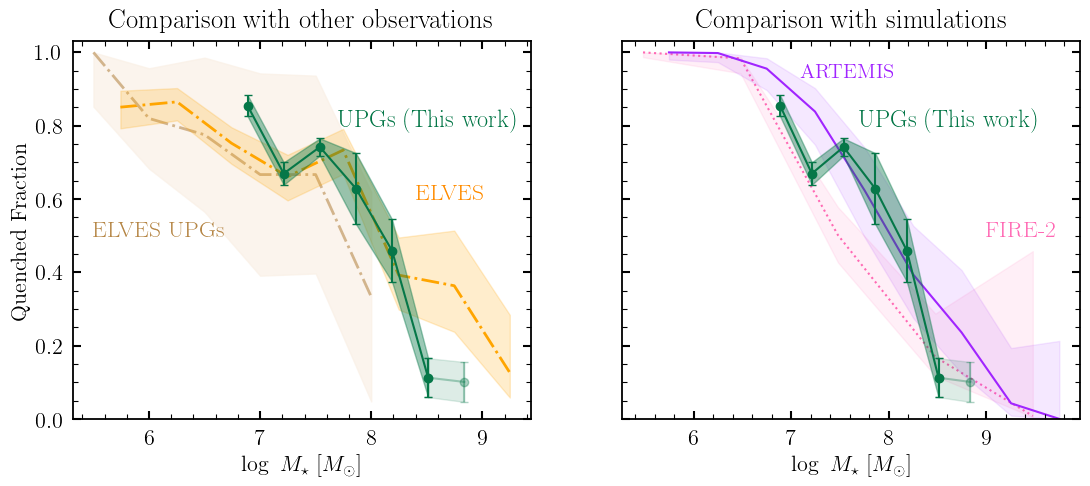

In [36]:
# fig, ax1 = plt.subplots(figsize=(6.5, 5))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UPG only figure including ELVES UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
                         plot_saga=False, plot_elves=True, plot_elves_upg=True)


# ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
# ax1.text(7.7, 0.85, 'UPGs (This work)', color='#057748', fontsize=17)
# ax1.text(6.6, 0.25, 'UPGs (This work)', color='#057748', fontsize=17.5)
ax1.text(7.7, 0.8, 'UPGs (This work)', color='#057748', fontsize=17.5)
ax1.text(8.4, 0.6, 'ELVES', color='darkorange', fontsize=17)
ax1.text(5.5, 0.5, 'ELVES UPGs', color='#b68747', fontsize=17)
ax1.set_title('Comparison with other observations')
# ax1.text(6.7, 0.97, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax1.add_artist(leg)

# k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
# b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
# plt.legend(handles=[k_line, b_line], 
#            fontsize=16, 
#            loc='lower left',
#            labelspacing=0.3,
#            handletextpad=0.4,
#            bbox_to_anchor=(-0.01, -0.02)
#           )
plt.ylim(0, 1.03)


flag_thresh = 1.2
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
                         plot_saga=False, plot_elves=False, plot_elves_upg=False, plot_sim=True)
ax2.set_ylabel('')
ax2.text(7.7, 0.8, 'UPGs (This work)', color='#057748', fontsize=17.5)
# ax2.text(8.4, 0.6, 'ELVES', color='darkorange', fontsize=17)
# ax2.text(5.5, 0.5, 'ELVES UPGs', color='#b68747', fontsize=17)
ax2.text(7.09, 0.93, 'ARTEMIS', color='#a125ff', fontsize=15)
ax2.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)
ax2.set_title('Comparison with simulations')
plt.ylim(0, 1.03)

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_elves_sim.pdf', 
            bbox_inches='tight', dpi=50)

### Big figure

In [32]:
import matplotlib.lines as mlines
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

#### Host color

Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96


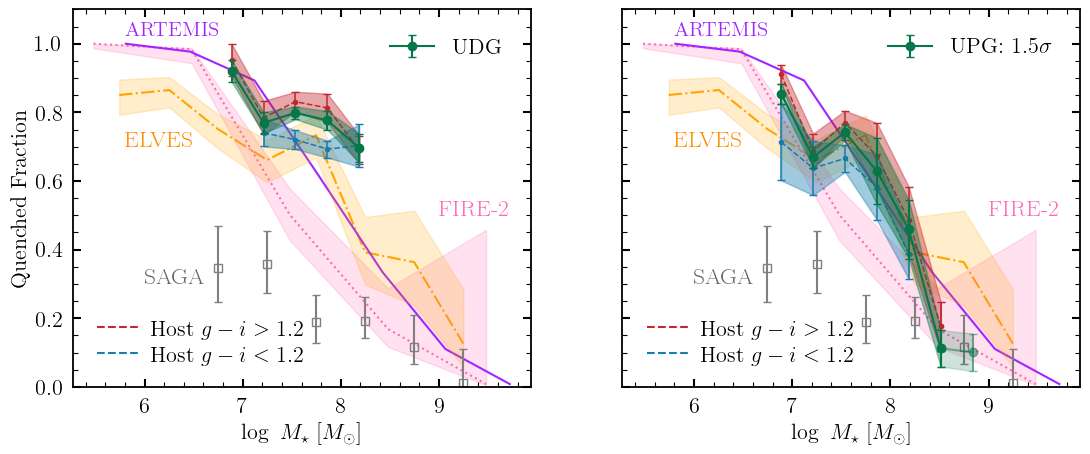

In [54]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]


_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax1.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
           handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_gi'] < flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax2.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
ax2.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
           handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_host_color_new.pdf', 
            bbox_inches='tight', dpi=50)

Total angular area [deg2]: 89.19
% of contaminants in the sample: 45.58 +- 5.96


(0.0, 1.03)

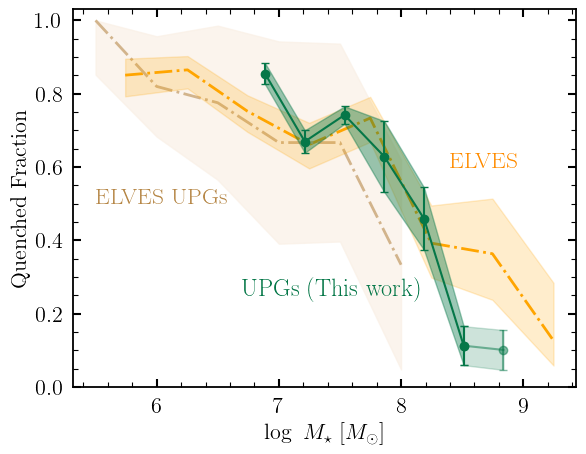

In [35]:
fig, ax1 = plt.subplots(figsize=(6.5, 5))

### UPG only figure including ELVES UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
                         plot_saga=False, plot_elves=True, plot_elves_upg=True)


# ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
# ax1.text(7.7, 0.85, 'UPGs (This work)', color='#057748', fontsize=17)
ax1.text(6.7, 0.25, 'UPGs (This work)', color='#057748', fontsize=17.5)
ax1.text(8.4, 0.6, 'ELVES', color='darkorange', fontsize=17)
ax1.text(5.5, 0.5, 'ELVES UPGs', color='#b68747', fontsize=17)
# ax1.text(6.7, 0.97, 'ARTEMIS', color='#a125ff', fontsize=15)
# ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax1.add_artist(leg)

# k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
# b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
# plt.legend(handles=[k_line, b_line], 
#            fontsize=16, 
#            loc='lower left',
#            labelspacing=0.3,
#            handletextpad=0.4,
#            bbox_to_anchor=(-0.01, -0.02)
#           )
plt.ylim(0, 1.03)
# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_elves.pdf', 
#             bbox_inches='tight', dpi=50)

In [12]:
samuel_q = np.array([[5.48, 1],
                     [6.48, 0.9837662337662338],
                     [7.48, 0.5016233766233766],
                     [8.48, 0.168831168831169],
                     [9.48, 0.008116883116883189]])
samuel_q_lower = np.array([[5.48, 0.9870129870129871],
                           [6.48, 0.9431818181818183],
                           [7.48, 0.4269480519480521],
                           [8.48, 0.11688311688311703],
                           [9.48, 0.004870129870129913]])
samuel_q_upper = np.array([[5.48, 1.0],
                           [6.48, 0.9870129870129871],
                           [7.48, 0.5779220779220781],
                           [8.48, 0.28733766233766234],
                           [9.48, 0.45779220779220786]])

Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04


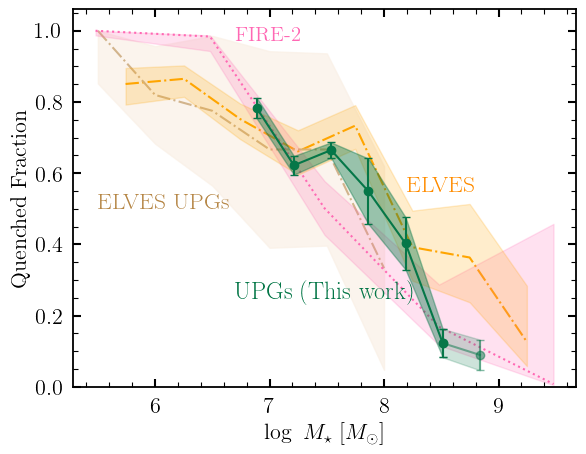

In [15]:
fig, ax1 = plt.subplots(figsize=(6.5, 5))

### UPG only figure including ELVES UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 1.2
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, 
                         plot_ref=False, plot_elves=True, plot_upg=True)


# ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
# ax1.text(7.7, 0.85, 'UPGs (This work)', color='#057748', fontsize=17)
ax1.text(6.7, 0.25, 'UPGs (This work)', color='#057748', fontsize=17.5)
ax1.text(8.2, 0.55, 'ELVES', color='darkorange', fontsize=17)
ax1.text(5.5, 0.5, 'ELVES UPGs', color='#b68747', fontsize=17)
ax1.text(6.7, 0.97, 'FIRE-2', color='hotpink', fontsize=15)
# ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

plt.plot(samuel_q[:, 0], samuel_q[:, 1],
         color='hotpink',  # label='ELVES',
         ls=':', zorder=0, alpha=1, lw=1.5)
plt.fill_between(samuel_q[:, 0],
                 samuel_q_lower[:, 1],
                 samuel_q_upper[:, 1],
                 color='hotpink',
                 alpha=0.2, zorder=0)

# handles, labels = plt.gca().get_legend_handles_labels()
# order = [0] #[1, 0, 2]
# leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
#            #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
#                 )
# ax1.add_artist(leg)

# k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $g-i > ' + f'{flag_thresh}$')
# b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $g-i < ' + f'{flag_thresh}$')
# plt.legend(handles=[k_line, b_line], 
#            fontsize=16, 
#            loc='lower left',
#            labelspacing=0.3,
#            handletextpad=0.4,
#            bbox_to_anchor=(-0.01, -0.02)
#           )

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_elves.pdf', 
#             bbox_inches='tight', dpi=50)

#### Radial distance

Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
% of contaminants in the sample: 34.39 +- 5.45
Total angular area [deg2]: 89.19904707251214
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96
% of contaminants in the sample: 45.59 +- 5.96


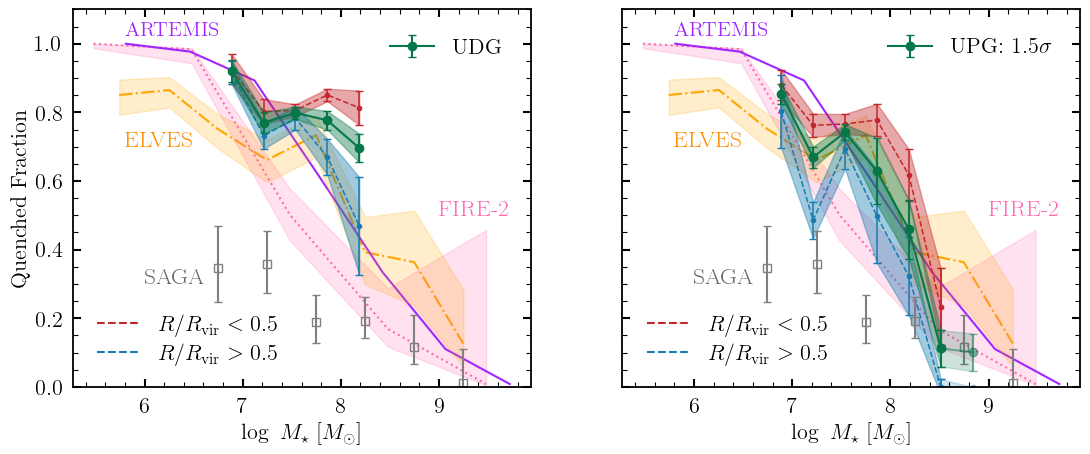

In [56]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)
ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax1.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
ax1.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
#            handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
total_area = 89.19904707251214
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

flag_thresh = 0.5
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio <= flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(dist_ratio > flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False, plot_elves=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
ax2.text(5.8, 1.02, 'ARTEMIS', color='#a125ff', fontsize=15)
ax2.text(9, 0.5, 'FIRE-2', color='hotpink', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'$R/R_{\rm vir} < ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'$R/R_{\rm vir} > ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           labelspacing=0.3,
#            handletextpad=0.4,
           bbox_to_anchor=(-0.01, -0.02)
          )
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/quenched_frac_dist2host_new.pdf', 
            bbox_inches='tight', dpi=50)

#### Host stellar mass

Total angular area [deg2]: 32.70887732960614
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04


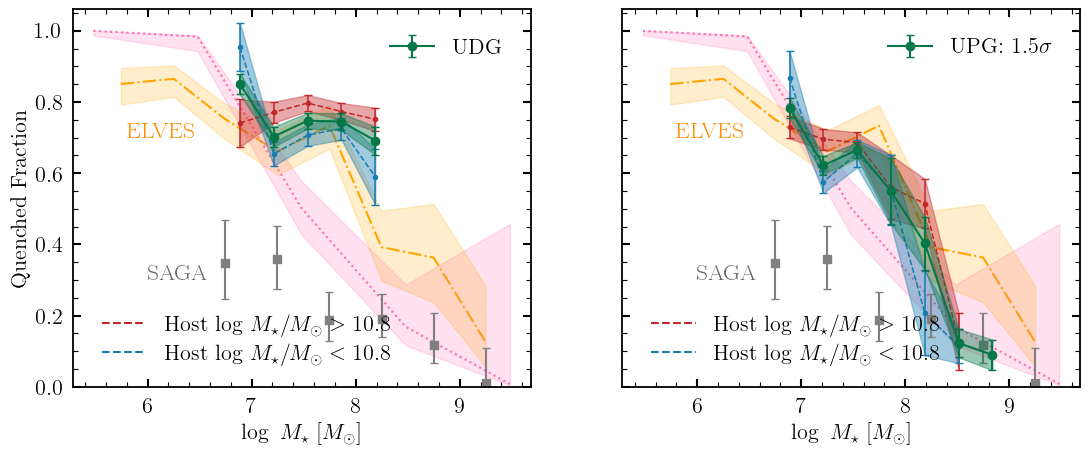

In [47]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg


flag_thresh = 10.8
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

flag_thresh = 10.8
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_stellar_mass'] <= flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### Redshift

Total angular area [deg2]: 32.70887732960614
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04


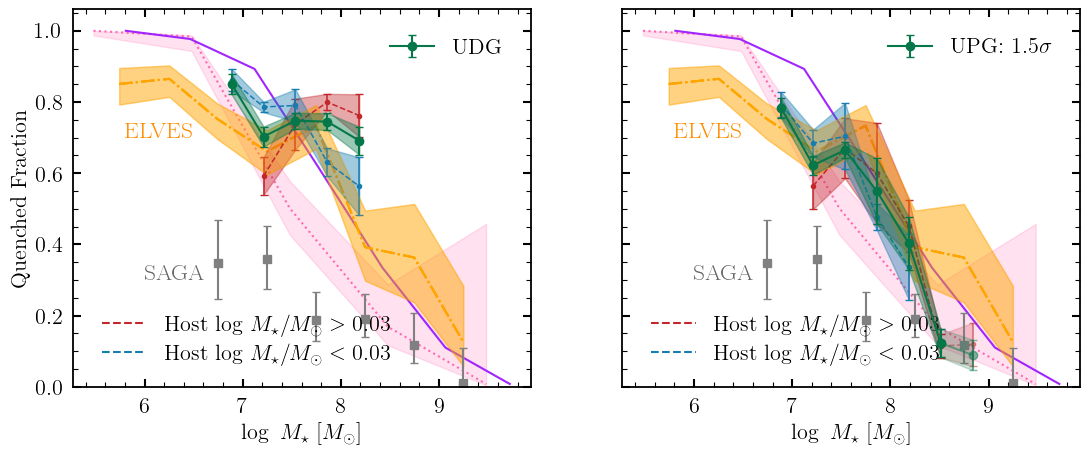

In [113]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg


flag_thresh = 0.03
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_z'] > flag_thresh), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_z'] < flag_thresh), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

flag_thresh = 0.03
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_z'] > flag_thresh), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_z'] <= flag_thresh), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

### Morphology

Total angular area [deg2]: 32.70887732960614
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
% of contaminants in the sample: 16.14 +- 2.66
Total angular area [deg2]: 32.36912377009267
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04
% of contaminants in the sample: 20.32 +- 2.04


Text(0, 0.5, '')

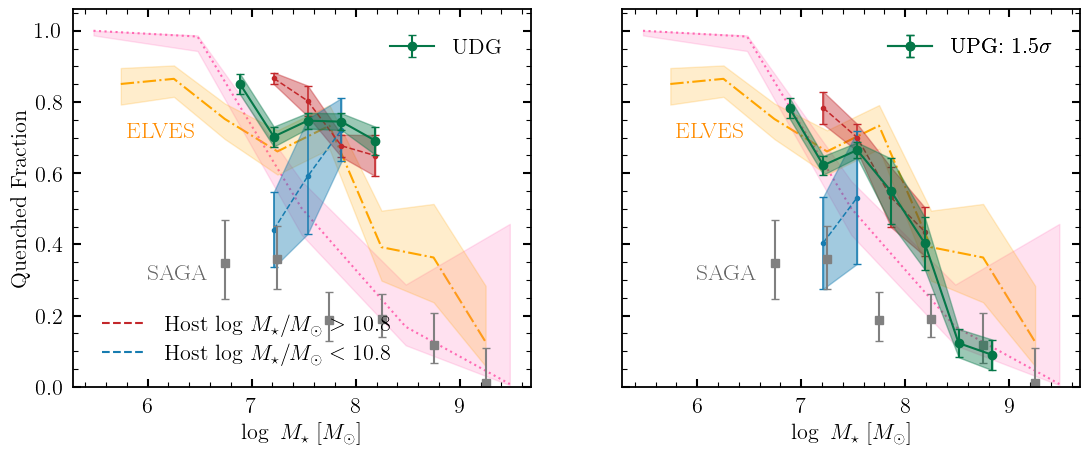

In [56]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
# thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg


flag_thresh = 10.8
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper(), flag=None, 
                         ax=ax1, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_spiral'].data.data == 0), 
                         ax=ax1, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax1 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_spiral'].data.data == 1), 
                         ax=ax1, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax1.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax1.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax1.add_artist(leg)

k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
plt.legend(handles=[k_line, b_line], 
           fontsize=16, 
           loc='lower left',
           bbox_to_anchor=(0, -0.02)
          )

# ### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

flag_thresh = 10.8
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=name.upper() + f': ${thresh}\sigma$', flag=None, 
                         ax=ax2, linecolor='#057748', linealpha=1, zorder=10, linewidth=1.5, plot_ref=True)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_spiral'].data.data == 0), 
                         ax=ax2, linecolor='#c3272b', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)
fig, ax2 = quenched_frac(udg_cat, fake_udg_cat, fake_udg_num, total_area, 24, fake_udg_repeats=10*20, 
                         min_completeness=0.1, quench_is_color=False, quenched_intercept=-0.23, 
                         name=None, flag=(udg_cat['host_spiral'].data.data == 1), 
                         ax=ax2, linecolor='#177cb0', linealpha=1, fmt='.--', linewidth=1.1, plot_ref=False)

ax2.text(6, 0.3, 'SAGA', color='dimgrey', fontsize=17)
ax2.text(5.8, 0.7, 'ELVES', color='darkorange', fontsize=17)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0] #[1, 0, 2]
leg = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           #ncol=3, bbox_to_anchor=(1., 0.66, 0.5, 0.5)
                )
ax2.add_artist(leg)
ax2.set_ylabel('')

# k_line = mlines.Line2D([], [], ls='--', color='#c3272b', label=r'Host $\log\,M_\star/M_\odot > ' + f'{flag_thresh}$')
# b_line = mlines.Line2D([], [], ls='--', color='#177cb0', label=r'Host $\log\,M_\star/M_\odot < ' + f'{flag_thresh}$')
# plt.legend(handles=[k_line, b_line], 
#            fontsize=16, 
#            loc='lower left',
#            bbox_to_anchor=(0, -0.02)
#           )

Total angular area [deg2]: 17.019095304816766
Total angular area [deg2]: 32.632327280019645


(array([0.734234  , 1.50039121, 1.24500547, 1.14923582, 1.53231443,
        0.98961974, 0.70231078, 1.24500547, 0.98961974, 0.79808043]),
 array([0.0802539 , 0.17211655, 0.2639792 , 0.35584185, 0.4477045 ,
        0.53956715, 0.6314298 , 0.72329244, 0.81515509, 0.90701774,
        0.99888039]),
 [<matplotlib.patches.Polygon at 0x2ad0dc97a7a0>])

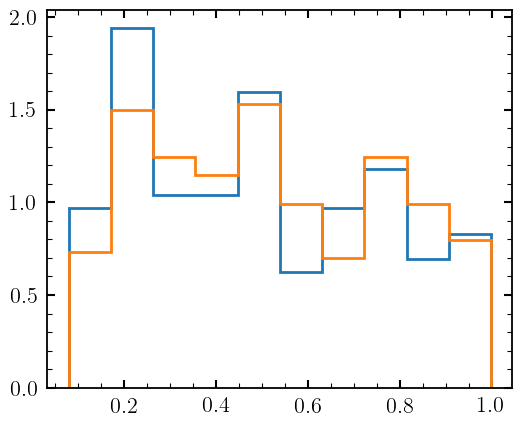

In [32]:
### UPG ###
name = 'upg'
thresh = 2
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data


plt.hist(dist_ratio, lw=2, histtype='step', density=True)


### UPG ###
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726_{name}_num.npy')
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

plt.hist(dist_ratio, lw=2, histtype='step', density=True)


In [46]:
name = 'upg'
thresh = 1.5
udg_cat15 = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')


thresh = 2
udg_cat20 = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

In [50]:
udg_cat_15_20 = udg_cat15[~np.in1d(udg_cat15['viz-id'], udg_cat20['viz-id'])]

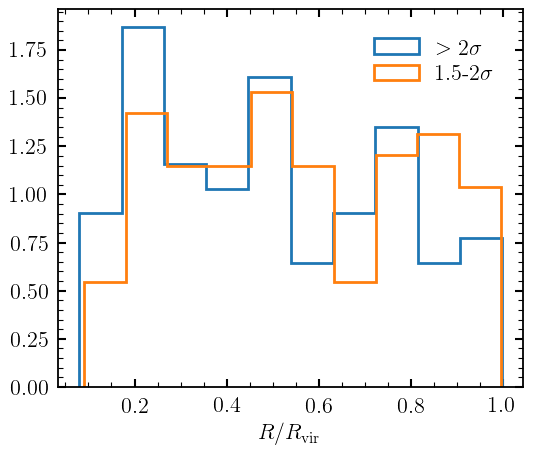

In [60]:
### UPG ###
udg_coord = SkyCoord(udg_cat20['ra'], udg_cat20['dec'], unit='deg')
host_coord = SkyCoord(udg_cat20['host_RA'], udg_cat20['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat20['host_r_vir_ang'].data

plt.hist(dist_ratio, lw=2, histtype='step', density=True, label='$>2\sigma$')

### UPG ###
udg_coord = SkyCoord(udg_cat_15_20['ra'], udg_cat_15_20['dec'], unit='deg')
host_coord = SkyCoord(udg_cat_15_20['host_RA'], udg_cat_15_20['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat_15_20['host_r_vir_ang'].data

plt.hist(dist_ratio, lw=2, histtype='step', density=True, label='1.5-2$\sigma$')

plt.xlabel(r'$R/R_{\rm vir}$')
plt.legend()